<a href="https://colab.research.google.com/github/dalexa10/Python_Data_Science/blob/main/Statistical_Modeling/HBM/bayesian_hierarchical_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Statistical modeling
##Bayesian Hierarchical Model

###Rat Tumor Example


Rats have been used in many experiments to evaluate the effect of drugs on development of tumors.

Tumors may develop even if no drug is administered (zero dose).
What is the baseline probability of a tumor?

A survey of 71 different experiments is conducted, recording

- I Number of rats in control (zero-dose) group
- I Number of control group rats developing a tumor

For this example you might have to install `pymc3` package. This might vary from what I used in Colab

In [3]:
!pip3 install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 52.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=146a13b90ffcd123cf28dd71e70fb3164a1fd17be680bcee714dbd05de00694d
  Stored in directory: /root/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc


\\

Now import all packages that will be used in the notebook

In [5]:
import math
import random
import numpy as np
import pandas as pd
# import graphviz
# from pymc3 import model_to_graphviz
import pymc3 as pm
from pymc3 import Model, sample, Beta, Binomial, Exponential, Uniform, summary, plot_posterior, model_to_graphviz, Deterministic
import matplotlib.pyplot as plt
# import os
# os.environ["PATH"] += os.pathsep + 'C:\Program Files\Python37\Lib\site-packages\graphviz\dot.py'

Let's import the data, where:
- $N_j$ = total number of rats in control group of experiment $j$
- $y_j$ = number in control group of experiment $j$ that develop a tumor
- $j$ = Experiment number 0,1 ..., 70

Assume $N_j$ fixed and $y_j$ random

In [7]:
url_data = 'https://raw.githubusercontent.com/dalexa10/Python_Data_Science/main/Statistical_Modeling/HBM/rattumor.txt'
df = pd.read_csv(url_data, sep=' ').iloc[:,:2]
df.shape
df.head(5)

,y,N
0,0,20
1,0,20
2,0,20
3,0,20
4,0,20


In [19]:
df.tail(5)

,y,N
66,16,52
67,15,46
68,15,47
69,9,24
70,4,14


Let's see some summarized info of this dataframe given by pandas automatically

In [9]:
df.describe()

,y,N
count,71.000000,71.000000
mean,3.760563,24.492958
std,3.811504,10.973830
min,0.000000,10.000000
25%,1.000000,19.000000
50%,3.000000,20.000000
75%,5.000000,22.500000
max,16.000000,52.000000


A naive estimate of $\theta_j$ is $\hat{\theta}_j = y_j/n_j$

Let's see how this histogram looks like with 18 bins

<function matplotlib.pyplot.show(*args, **kw)>

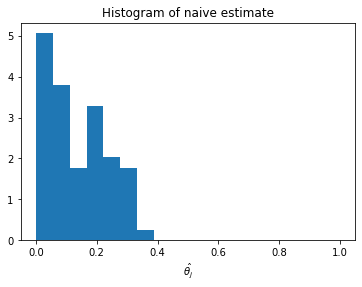

In [14]:
plt.hist(df.y / df.N, range = (0,1), bins = 18, density=True)
plt.title("Histogram of naive estimate")
plt.xlabel(r'$\hat{\theta_j}$')
plt.show

The aim is to model $\theta_j$'s as if independent from the same distribution

In Bayesian inference, the beta distribution is the conjugate prior probability distribution for the Bernoulli and binomial distributions.

So try
\begin{aligned}
  \theta_j \sim Beta(\alpha, \beta)
\end{aligned}

Hence, the model has two levels
- Lower level:  $y_j | \theta_j \sim Bin(n_j, \theta_j)$
- Upper level: $\theta_j \sim Beta(\alpha, \beta)$

Both $\alpha$ and $\beta$ (called hyperparameters) must be selected from:
- Guess (subjective)
- Use prior information (if available)
- Estimate from data ("Empirical Bayes")
- Give them a prior distribution ("Hierarchical Bayes")

Recall: a prior on hyperparameters is a **hyperprior**

Now, let's try for example

\begin{aligned}
  \alpha, \beta \sim  Expon(\lambda) \ \ \  for \ some \ \lambda>0  
\end{aligned}
This can be made less informative (flatter) by choosing $\lambda$ closer to zero

In [20]:
with Model() as model1:
    # Note: Hyperpriors are exponentials with lambda values close to zero
    
    # Priors
    alpha = Exponential('alpha', 0.001)  
    beta = Exponential('beta', 0.001)

    theta = Beta('theta', alpha=alpha, beta=beta, shape=71)

    # Data likelihood
    y_like = Binomial('y_like', n=df.N, p=theta, observed=df.y)

Note that `model1` is a Context Manager (instantiated) and it that was returned from the general `Model()` Context Manager

Note that each simulation is random and hence, it will generate different results each time you run this

In [23]:
random.seed(100)
with model1:
    trace1 = sample(100, tune=100)

/usr/local/lib/python3.8/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


In [24]:
summary(trace1)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.232,1.110,1.463,5.431,0.173,0.125,44.0,80.0,1.01
beta,19.313,6.521,7.407,29.783,0.924,0.657,51.0,106.0,1.02
theta[0],0.075,0.044,0.005,0.158,0.004,0.003,113.0,106.0,1.06
theta[1],0.074,0.046,0.006,0.155,0.003,0.002,179.0,156.0,0.99
theta[2],0.072,0.038,0.005,0.134,0.003,0.002,160.0,136.0,1.01
...,...,...,...,...,...,...,...,...,...
theta[66],0.260,0.057,0.181,0.385,0.003,0.002,460.0,142.0,0.99
theta[67],0.266,0.059,0.162,0.375,0.003,0.002,344.0,150.0,1.06
theta[68],0.263,0.056,0.153,0.365,0.003,0.002,436.0,183.0,1.03
theta[69],0.264,0.058,0.159,0.385,0.003,0.002,309.0,123.0,1.03


Now, let's see the nature of both $\alpha$ and $\beta$ hyperparameters

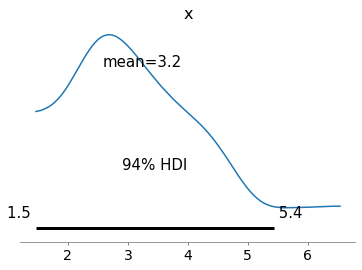

In [25]:
plot_posterior(trace1['alpha'])

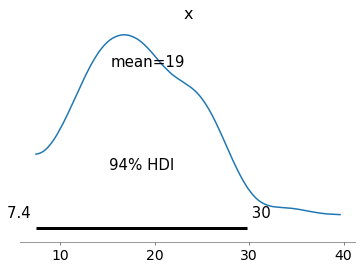

In [26]:
plot_posterior(trace1['beta'])

What about a scatter plot 

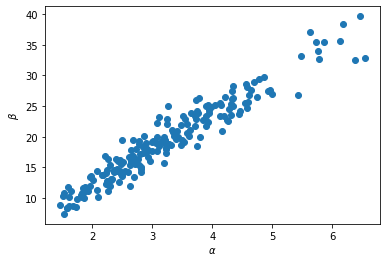

In [30]:
alpha = trace1.get_values(varname='alpha')
beta = trace1.get_values(varname='beta')
plt.scatter(alpha, beta)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.show()

A more meaningful plot is $\alpha + \beta$ vs $\alpha / \beta$ in log scales  

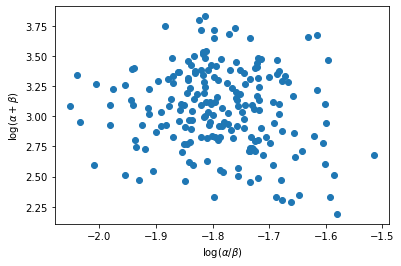

In [31]:
plt.scatter(np.log(alpha/beta), np.log(alpha+beta))
plt.xlabel(r'log($\alpha / \beta$)')
plt.ylabel(r'log($\alpha + \beta$)')
plt.show()

It seems that exponential hyperpriors do not diffuse enought. Let's try a different (less informative) prior...

Now, let's try another prior. Consider:

\begin{aligned}
  \phi_1 = \frac{\alpha}{\alpha + \beta} \sim U(0,1) \\
  \phi_2 = (\alpha + \beta)^{-\frac{1}{2}} \sim U(0,1000) \\ 
  \alpha = \phi_1 / \phi_2^2 \\
  \beta = (1 - \phi_1) / \phi_2^2
\end{aligned}

In [32]:
with Model() as model2:

    phi1 = Uniform('phi1', lower=0, upper=1)
    phi2 = Uniform('phi2', lower=0, upper=1000)

    alpha = Deterministic('alpha', phi1 / (phi2**2))
    beta = Deterministic('beta', (1-phi1) / phi2**2)

    theta = Beta('theta', alpha=alpha, beta=beta, shape=71)

    # Data likelihood
    y_like = Binomial('y_like', n=df.N, p=theta, observed=df.y)

In [35]:
random.seed(100)
with model2:
    trace2 = sample(100, tune=100)

/usr/local/lib/python3.8/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


In [36]:
summary(trace2)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
phi1,0.142,0.013,0.117,0.166,0.001,0.001,206.0,88.0,1.00
phi2,0.264,0.041,0.194,0.344,0.007,0.005,29.0,150.0,1.08
alpha,2.187,0.713,1.153,3.559,0.134,0.096,29.0,119.0,1.07
beta,13.307,4.397,5.439,20.402,0.913,0.654,30.0,135.0,1.08
theta[0],0.059,0.041,0.005,0.127,0.003,0.002,189.0,139.0,1.00
...,...,...,...,...,...,...,...,...,...
theta[66],0.271,0.053,0.161,0.366,0.003,0.002,341.0,157.0,1.01
theta[67],0.283,0.062,0.186,0.412,0.005,0.004,148.0,153.0,1.02
theta[68],0.275,0.055,0.171,0.365,0.004,0.003,228.0,88.0,1.01
theta[69],0.278,0.068,0.159,0.394,0.005,0.004,180.0,105.0,1.00


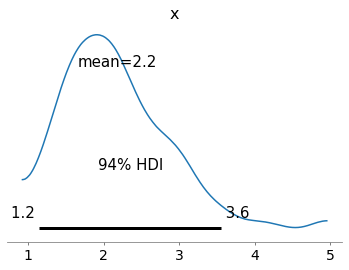

In [37]:
plot_posterior(trace2['alpha'])

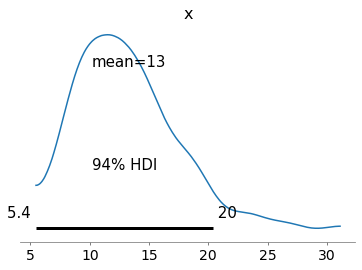

In [38]:
plot_posterior(trace2['beta'])

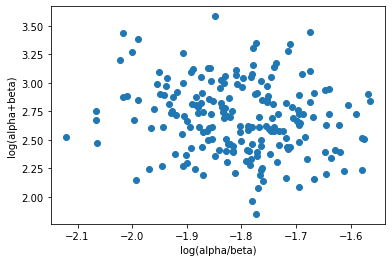

In [39]:
alpha2 = trace2.get_values(varname='alpha')
beta2 = trace2.get_values(varname='beta')
plt.scatter(np.log(alpha2/beta2), np.log(alpha2+beta2))
plt.xlabel('log(alpha/beta)')
plt.ylabel('log(alpha+beta)')
plt.show()